In [12]:
import os
import numpy as np
import torch
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import cv2
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
from torchvision import transforms as T
from PIL import Image
import random

vid_4_600.jpg


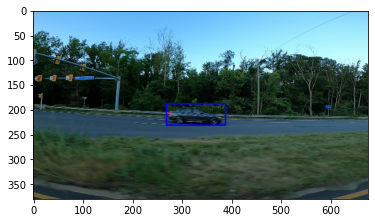

vid_4_620.jpg


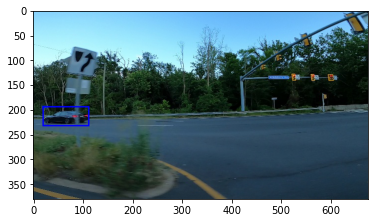

vid_4_680.jpg


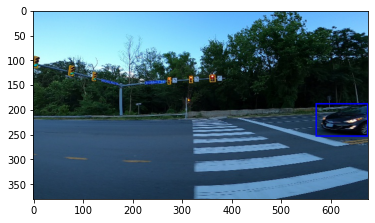

vid_4_740.jpg


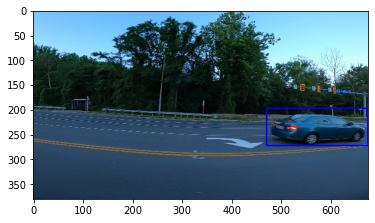

vid_4_860.jpg


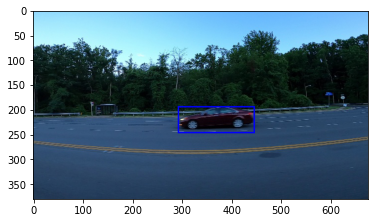

vid_4_880.jpg


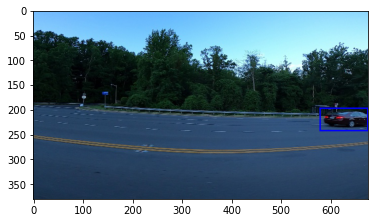

vid_4_900.jpg


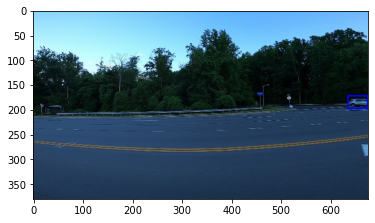

vid_4_920.jpg


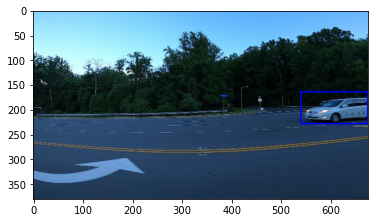

vid_4_960.jpg


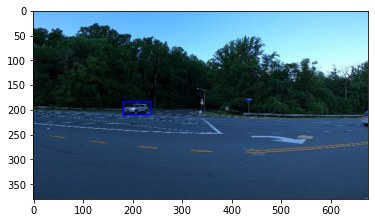

vid_4_980.jpg


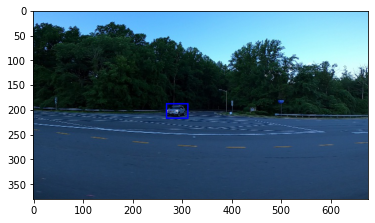

In [13]:
def randomflip(img,bb):
    if(random.random()>0.5):
        #img shape : (3,H,W)
        img = torch.flip(img,[2])
        bb_old = bb.clone()
        bb_old[0] /= img.shape[2]
        bb_old[2] /= img.shape[2]
        
        bb[0] = 1 - bb_old[2]
        bb[2] = 1 - bb_old[0]
        
        bb[0] *= img.shape[2]
        bb[2] *= img.shape[2]
    return(img,bb)
        
class Car_data(Dataset):
    def __init__(self,transform=None,transform_labels=None):
        super().__init__()
        self.transform = transform
        self.transform_labels = transform_labels
        self.car_img_df = pd.read_csv("Book1.csv")
        self.car_id_df = pd.read_csv("Book1.csv")
    
    def __len__(self):
        return self.car_id_df.shape[0]
        
    def __getitem__(self,idx):
        img = Image.open(os.path.join(r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\training_images",
                                      self.car_id_df.loc[idx]["image"]))
        box = self.car_img_df.loc[self.car_img_df['image']==self.car_id_df.loc[idx,'image'],["xmin","ymin","xmax","ymax"]].values
        box = box.reshape(-1)
        if self.transform_labels:
            box = self.transform_labels(box)
        
        img = T.ToTensor()(img)
        img,box = randomflip(img,box)
        default_img = img
        
        if self.transform:
            img = self.transform(img)
    
        target = box
        target[0] /= img.shape[2]
        target[2] /= img.shape[2]
        target[1] /= img.shape[1]
        target[3] /= img.shape[1]
        return img,target,default_img

#For Faster RCNN Model
trainable_dataset = Car_data(transform = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                          std=[0.229, 0.224, 0.225])]),
                             transform_labels = torch.Tensor)
def visualize_bb(indxs,colors="blue"):
    img_id_df = pd.read_csv("Book1.csv")
    img_csv_df = pd.read_csv("Book1.csv")
    for i in indxs:
        #item["img"].shape -> (C,H,W)
        print(img_csv_df.loc[i]["image"])
        img = Image.open(os.path.join(r"C:\Users\KARTIK BALI\Desktop\I2DL\archive\data\training_images",
                                      img_id_df.loc[i]["image"]))
        img = T.ToTensor()(img) * 255
        b_boxes = img_csv_df.loc[img_csv_df['image']==img_id_df.loc[i,'image'],["xmin","ymin","xmax","ymax"]].values
        b_box = torch.tensor(b_boxes,dtype = torch.float)
        b_box = b_box.reshape(-1)
        img, b_box = randomflip(img, b_box)
        
        resulting_img = draw_bounding_boxes(img.byte(),boxes = b_box.unsqueeze(0),
                                            width=3,colors = colors)
        #tensor.byte() casts the tensor as uint8 as opposed to tensor.int() and tensor.float() for int32 and float32
        #resulting_img.shape -> (C,H,W)
        #unsqueeze adds a 1 at the dimension specified. for ex. for list with shape (2,), list.unsqueeze(1)-> shape: (2,1)
        plt.imshow(resulting_img.permute(1,2,0))
        #permute is not the same as reshape, it transposes the img tensor such that image become (H,W,C) as suited for plotting 
        #in matplotlib
        plt.show()

visualize_bb([i for i in range(10)])

In [14]:
train_len = int(0.8*len(trainable_dataset))
val_len = len(trainable_dataset) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(trainable_dataset,[train_len,val_len])
batch_size = 16
train_dataloader = DataLoader(dataset = train_dataset,shuffle = True, batch_size=batch_size)
val_dataloader = DataLoader(dataset = val_dataset,shuffle = True, batch_size=batch_size)


In [15]:
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
    
    
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layer1 = torchvision.models.alexnet(pretrained= True).features[0:15]#(3,380,676) -> (64,94,168) -> (64,46,83) 
        #-> (192,46,83) -> (192,22,41) -> (384,22,41) -> (256,22,41) -> (256, 22, 41) -> (256,10,20)
        self.model = torchvision.models.resnet50(pretrained=True)
        self.num_features = self.model.fc.in_features
        #print(self.num_features)
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.fc = nn.Linear(self.num_features,1024)
        self.linear_layer1 = nn.Sequential(nn.ReLU(),
                                           nn.Linear(1024,512),
                                           nn.ReLU(),
                                           nn.Linear(512,256),
                                           nn.ReLU(),
                                           nn.Linear(256,16),
                                           nn.ReLU(),
                                           nn.Linear(16,4),
                                           nn.Sigmoid())
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(256,128,3,stride=1,padding="same"),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,stride=2))
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Sequential(nn.Linear(6400,3200),
                                            nn.ReLU(),
                                            nn.Linear(3200,1000),
                                            nn.ReLU(),
                                            nn.Linear(1000,500),
                                            nn.ReLU(),
                                            nn.Linear(500,4),
                                            nn.Sigmoid()
                                            )
    def forward(self,x):
        #with torch.no_grad():
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = self.flatten(x)
        x = self.linear_layer(x)
        '''x = self.model(x)
        x = self.linear_layer1(x)'''
        return(x)

#CNN() is a bounding box regressor model
model = CNN()

In [18]:
import gc

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)

#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

##training loop
def training_loop(train_dataloader,loss_fn,optimizer,epoch,batch_size):
    train_loss = 0
    num_batches = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for X,y,_ in train_dataloader:
        
        X,y = X.to(device),y.to(device)
        preds = model(X)
        #print(preds.shape,",",y.shape)
        loss = loss_fn(preds,y)
        
        optimizer.zero_grad()
        #For CNN() Regressor
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
        
        #Free CUDA Memory
        del X,y
        gc.collect()
        torch.cuda.empty_cache()
    print(" Train_loss:",train_loss/num_batches,end="")
    writer.add_scalar("Training Loss",train_loss/num_batches,epoch)
        
def validation_loop(val_dataloader,loss_fn,epoch,batch_size):
    val_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_batches = 1
    for X,y,_ in val_dataloader:
        #For CNN Regressor
        X,y = X.to(device),y.to(device)
        preds = model(X)
        loss = loss_fn(preds,y)
        val_loss += loss.item()
        
        num_batches += 1
        
        #Free CUDA Memory
        del X,y
        gc.collect()
        torch.cuda.empty_cache()
    print(" Val_loss:",val_loss/num_batches)
    writer.add_scalar("Val Loss",val_loss/num_batches,epoch)

num_epochs=20
for epoch in range(num_epochs):
    print("Epoch: ",epoch,"/",num_epochs,end="")
    training_loop(train_dataloader, loss_fn, optimizer, epoch,batch_size)
    validation_loop(val_dataloader, loss_fn, epoch,batch_size)
    writer.flush()

Epoch:  0 / 20 Train_loss: 0.0005601974486265904 Val_loss: 0.0026062530814670026
Epoch:  1 / 20 Train_loss: 0.0004900800413452089 Val_loss: 0.0025728594046086073
Epoch:  2 / 20 Train_loss: 0.00039832469841572817 Val_loss: 0.0025203671539202332
Epoch:  3 / 20 Train_loss: 0.0003161903631945069 Val_loss: 0.002819784014718607
Epoch:  4 / 20 Train_loss: 0.0003107654461368489 Val_loss: 0.00299537178943865
Epoch:  5 / 20 Train_loss: 0.00025107973711923335 Val_loss: 0.003146846021991223
Epoch:  6 / 20 Train_loss: 0.00023623616009270056 Val_loss: 0.0025466555380262434
Epoch:  7 / 20 Train_loss: 0.00018543966815251714 Val_loss: 0.0029124776483513415
Epoch:  8 / 20 Train_loss: 0.00021533806956050775 Val_loss: 0.003153586178086698
Epoch:  9 / 20 Train_loss: 0.00014196962617391435 Val_loss: 0.0030086005572229624
Epoch:  10 / 20 Train_loss: 0.0001360796478156072 Val_loss: 0.00296445848653093
Epoch:  11 / 20 Train_loss: 0.00011782217300676096 Val_loss: 0.002466148231178522
Epoch:  12 / 20 Train_loss:

tensor([[336.1827, 186.9256, 424.4470, 223.6927]], grad_fn=<CopySlices>)


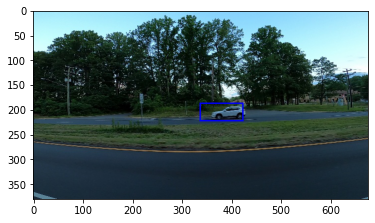

tensor([[530.5383, 191.5356, 645.3077, 235.0506]], grad_fn=<CopySlices>)


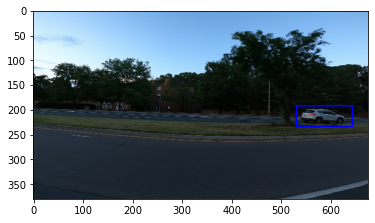

tensor([[402.2382, 189.0503, 518.4676, 239.2485]], grad_fn=<CopySlices>)


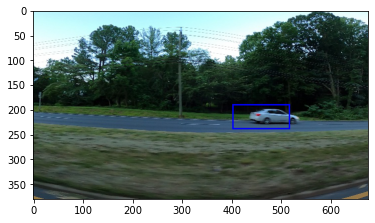

tensor([[  5.0099, 195.2063,  57.5845, 231.6499]], grad_fn=<CopySlices>)


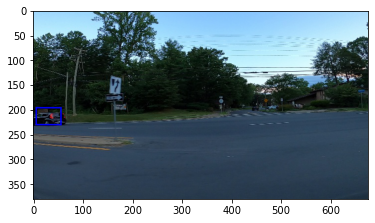

tensor([[396.7663, 187.2041, 503.0328, 235.6348]], grad_fn=<CopySlices>)


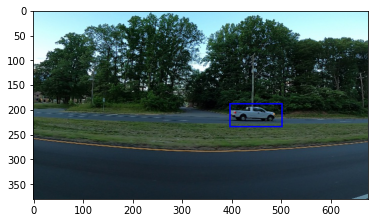

tensor([[622.0136, 190.4777, 672.1708, 261.2728]], grad_fn=<CopySlices>)


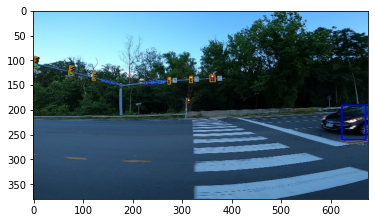

tensor([[582.1585, 182.9854, 645.5485, 216.0723]], grad_fn=<CopySlices>)


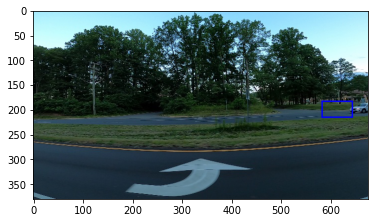

tensor([[617.2203, 186.5714, 668.9092, 223.5696]], grad_fn=<CopySlices>)


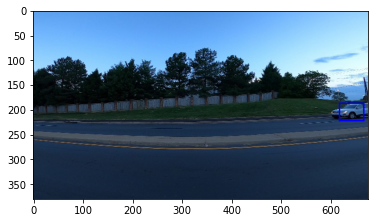

tensor([[519.8824, 174.9859, 641.9408, 235.8326]], grad_fn=<CopySlices>)


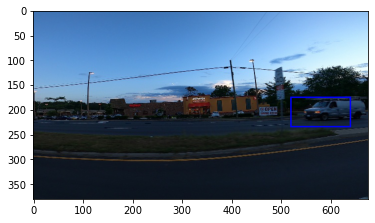

tensor([[ 18.5020, 194.9722, 137.4186, 250.5629]], grad_fn=<CopySlices>)


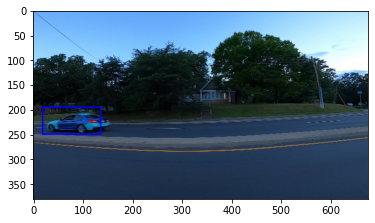

tensor([[362.9158, 175.1558, 499.6255, 226.6487]], grad_fn=<CopySlices>)


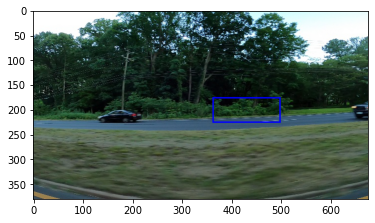

tensor([[ 34.3150, 181.4307, 155.6389, 223.4861]], grad_fn=<CopySlices>)


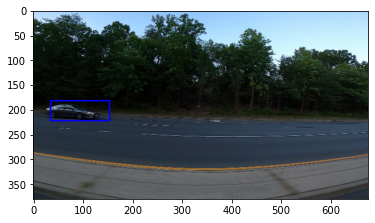

tensor([[554.2036, 187.1201, 646.0667, 226.3913]], grad_fn=<CopySlices>)


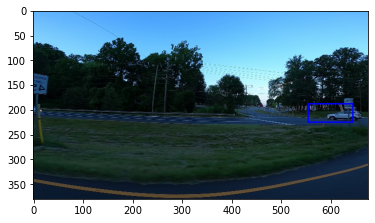

tensor([[482.9995, 179.1924, 607.5751, 218.4951]], grad_fn=<CopySlices>)


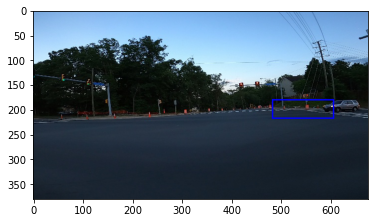

tensor([[ 71.0646, 176.0887, 203.1612, 233.4519]], grad_fn=<CopySlices>)


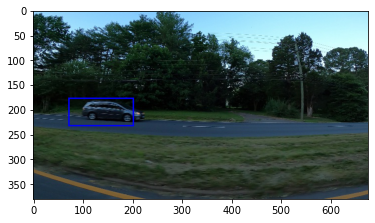

tensor([[624.8708, 198.7081, 669.2466, 235.9787]], grad_fn=<CopySlices>)


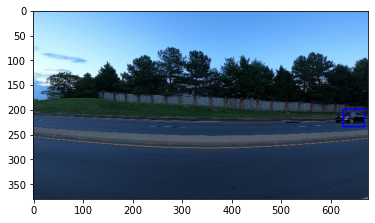

tensor([[307.7482, 190.1322, 438.6134, 247.9112]], grad_fn=<CopySlices>)


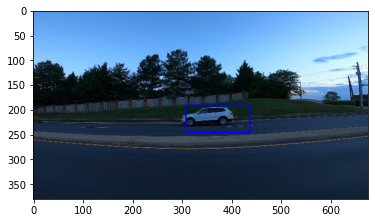

tensor([[624.7725, 185.5200, 672.3188, 234.6724]], grad_fn=<CopySlices>)


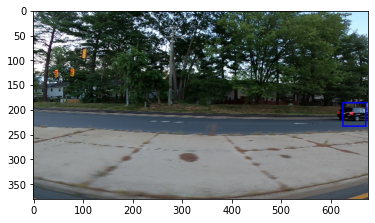

tensor([[ 53.0787, 177.7046, 155.1014, 222.6656]], grad_fn=<CopySlices>)


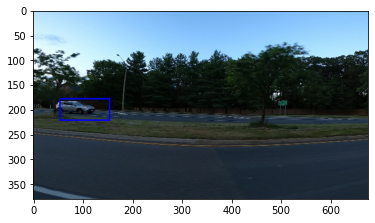

tensor([[ 76.6352, 183.4545, 181.9668, 232.5701]], grad_fn=<CopySlices>)


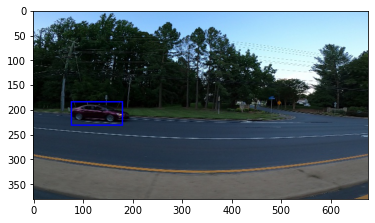

tensor([[106.4432, 187.3739, 217.5257, 232.2220]], grad_fn=<CopySlices>)


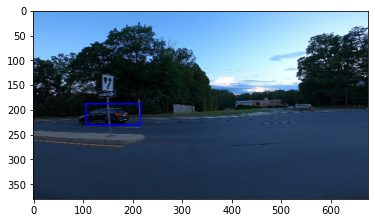

tensor([[298.4678, 190.2202, 437.1790, 233.4906]], grad_fn=<CopySlices>)


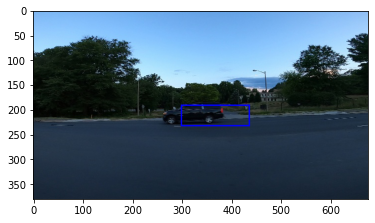

tensor([[115.5384, 182.9159, 235.0557, 232.0196]], grad_fn=<CopySlices>)


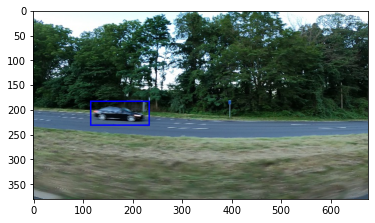

tensor([[303.3615, 183.6255, 433.4059, 234.8769]], grad_fn=<CopySlices>)


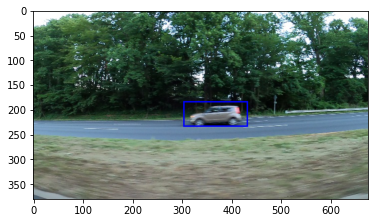

tensor([[ 89.3422, 178.3507, 196.2918, 215.9218]], grad_fn=<CopySlices>)


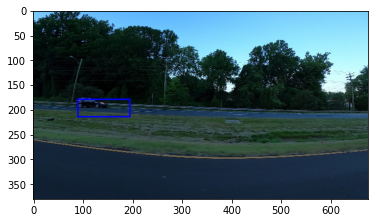

tensor([[218.3598, 187.5506, 368.3128, 246.5558]], grad_fn=<CopySlices>)


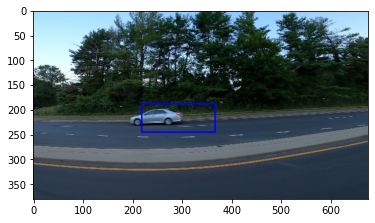

tensor([[ 21.0607, 195.0458, 151.6744, 242.3053]], grad_fn=<CopySlices>)


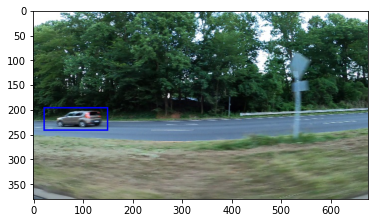

tensor([[248.0622, 188.1232, 394.3510, 245.3300]], grad_fn=<CopySlices>)


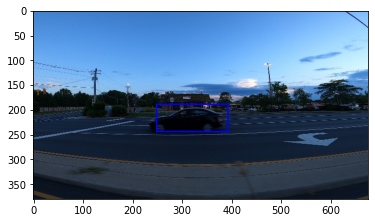

tensor([[ 30.0850, 189.7419, 147.6477, 237.0918]], grad_fn=<CopySlices>)


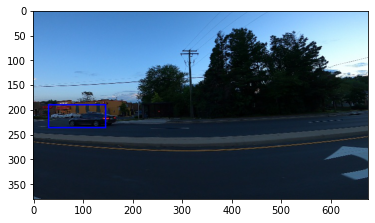

tensor([[527.6964, 181.7451, 652.2880, 236.9393]], grad_fn=<CopySlices>)


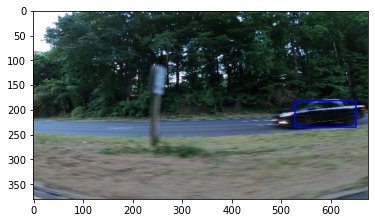

tensor([[ 22.6816, 178.0431, 128.3801, 233.5767]], grad_fn=<CopySlices>)


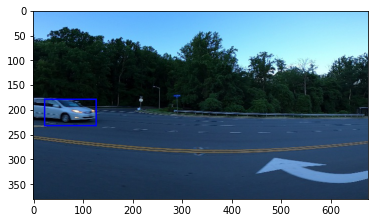

tensor([[  8.6108, 193.6766, 140.0922, 282.6966]], grad_fn=<CopySlices>)


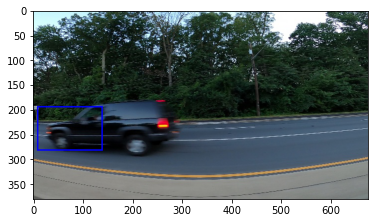

tensor([[ 10.5766, 179.4707,  83.1268, 219.6340]], grad_fn=<CopySlices>)


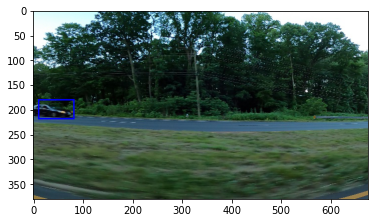

tensor([[550.8045, 195.0620, 663.4536, 241.2917]], grad_fn=<CopySlices>)


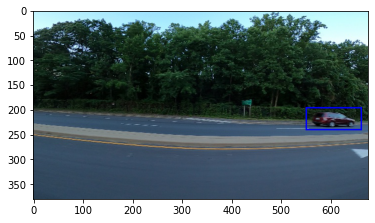

tensor([[242.4005, 189.1349, 416.9451, 248.4495]], grad_fn=<CopySlices>)


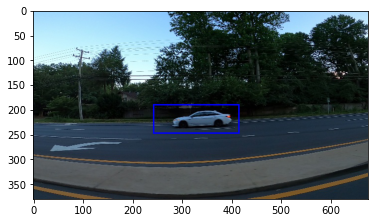

tensor([[ 74.7991, 187.1962, 201.3284, 234.5326]], grad_fn=<CopySlices>)


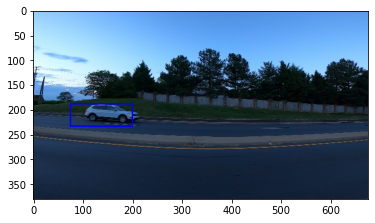

tensor([[537.8994, 179.1614, 646.7413, 235.1060]], grad_fn=<CopySlices>)


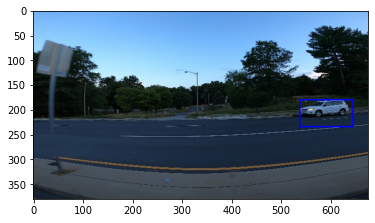

tensor([[  5.0593, 193.4164,  59.1321, 226.0323]], grad_fn=<CopySlices>)


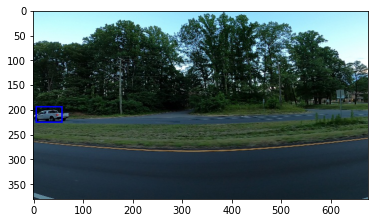

tensor([[563.5102, 185.4256, 641.9925, 220.9485]], grad_fn=<CopySlices>)


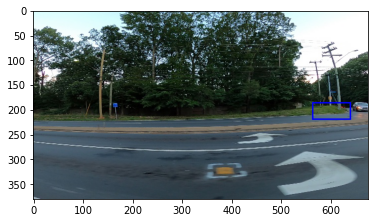

tensor([[105.6972, 178.5580, 202.7732, 216.8899]], grad_fn=<CopySlices>)


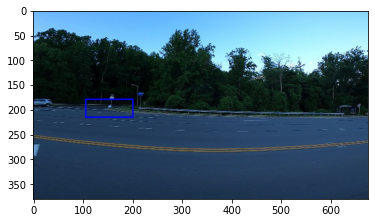

tensor([[511.8253, 183.3480, 634.8889, 222.4583]], grad_fn=<CopySlices>)


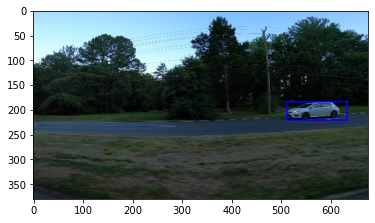

tensor([[ 32.8455, 179.4298, 144.7778, 218.7999]], grad_fn=<CopySlices>)


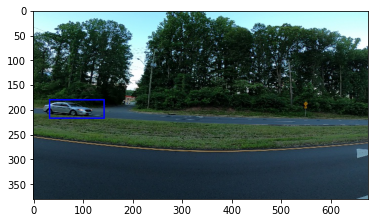

tensor([[167.7165, 186.3040, 269.7514, 227.8879]], grad_fn=<CopySlices>)


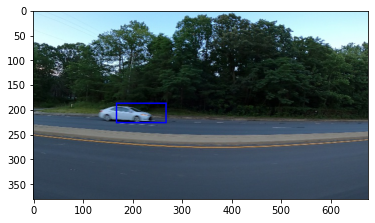

tensor([[348.9762, 187.7377, 484.2603, 234.8810]], grad_fn=<CopySlices>)


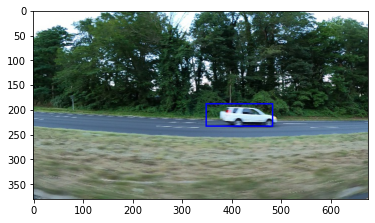

tensor([[124.8869, 173.8980, 319.2389, 254.3149]], grad_fn=<CopySlices>)


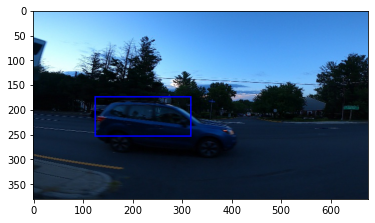

tensor([[  7.3653, 194.7976, 105.9866, 235.4680]], grad_fn=<CopySlices>)


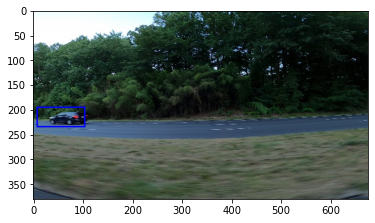

tensor([[359.4543, 188.2577, 502.6296, 241.2058]], grad_fn=<CopySlices>)


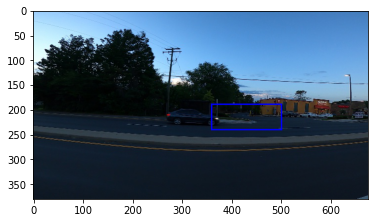

In [19]:
def visualize_predicted_bb(dataset,model,indxs):
    for i in indxs:
        image,target,default_img= dataset[i]
        image = image.unsqueeze(0)
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        device = torch.device("cpu")
        image = image.to(device)
        model = model.to(device)
        
        model.eval()
        box = model(image)
        default_img *= 255
        box[:,0] *= image.shape[3]
        box[:,2] *= image.shape[3]
        box[:,1] *= image.shape[2]
        box[:,3] *= image.shape[2]
        print(box)
        resulting_img = draw_bounding_boxes(default_img.byte(),box,colors = "blue",width=3)
        plt.imshow(resulting_img.permute(1,2,0))
        plt.show()
        
visualize_predicted_bb(val_dataset,model,[i for i in range(val_len)])